# Testing: Bidirectional + 3 GRU layers + 1024 latent dim
- Bidirectional + 3 GRU layers

**Reference, best result so far:**

**Conclusions:**
- sort of the same, forward or backward makes no big difference
- Bidirectional is clearly better (loss)
- 3 GRU layes does not make it better ...

Testing setup:               | Loss achieved                   | Speed         
---|---|---|
backward                     | loss: 1.3475 - val_loss: 1.7949 | 111 sec/epoch 
forward                      | loss: 1.3751 - val_loss: 1.8150 | 111 sec/epoch 
go_backwards parameter       | loss: 1.3947 - val_loss: 1.8325 | 111 sec/epoch 
bidirectional                | loss: 1.2247 - val_loss: 1.7828 | 185 sec/epoch 
bidir and latent_dim=1024    | loss: 0.8803 - val_loss: 1.7386 | 412 sec/epoch 
bidir and 3 GRU              | loss: 1.3554 - val_loss: 1.8040 | 216 sec/epoch 
bidir and 3 GRU and 1024 lat | loss: 1.2439 - val_loss: 1.8546 | 544 sec/epoch 

**Improvments to be implemented:**
- **Done** Reverse input string?
- "go_backwards" input to layer to test if it works like backwards?
- Indrease size of vocabulary, different for the two languages?
- More GRU layers?
- Bidirectional GRU layers
- **Done** Change Embedding size
- Try LSTM instead
- **Done** Larger latent_dim for GRU (=512?)
- try / understand 'TimeDistributed': decoder_dense = TimeDistributed(Dense(Y_lstm.shape[2], activation = 'relu'))
- dropout as layer
- L2 reg
- bi-directional layers: https://stackoverflow.com/questions/50815354/seq2seq-bidirectional-encoder-decoder-in-keras or https://www.programcreek.com/python/example/92259/keras.layers.wrappers.Bidirectional
- attention 
- Gradient clipping is important for RNNs training (clipvalue=1.0), book page 309
- **Done** deeper models to represent more complex sentences, more RNN layers?
- **Done** clean-up code around the internal states, lots of confusion around "[]"
- **Done** Smaller batch size, eg 32 vs 512 may give a getter val_loss? Proved to be that way with the chatbot!
- **Done** test Pandas dataframe for nice outputs (https://www.tutorialspoint.com/python_pandas/python_pandas_dataframe.htm)
- **Done** dropout in RNN layer:
- **Done** Simplify by suing GRU RNN
- **Done** ' to_categorical' as one-hot encoder, makes huge matrices
- **Done** "sparse_categorical_crossentropy" to reduce the 'one hot' tensor
- **Done** operates right now with long sentences: 8*std_div, shound be less when longer sentences are trained
- **Done** train on larger dataset
- **Done** something is wrong with the index of the one-hot; the model allows to return "0" as the best index, but the token2word starts from "1". It seems to be OK
- **Done** remove num_samples

**Credits to many fine people on the internet:**
- https://blog.keras.io/a-ten-minute-introduction-to-sequence-to-sequence-learning-in-keras.html
- https://medium.com/@dev.elect.iitd/neural-machine-translation-using-word-level-seq2seq-model-47538cba8cd7
- https://stackoverflow.com/questions/49477097/keras-seq2seq-word-embedding
- https://github.com/devm2024/nmt_keras/blob/master/base.ipynb
- https://www.kaggle.com/ievgenvp/lstm-encoder-decoder-via-keras-lb-0-5
- https://github.com/Hvass-Labs/TensorFlow-Tutorials/blob/master/21_Machine_Translation.ipynb

In [1]:
import os
import tensorflow as tf
import numpy as np

from keras.models import Model
from keras.layers import Input, Embedding, LSTM, GRU, Dense, Bidirectional, Concatenate
from tensorflow.python.keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard

C:\Users\ThomasGordon\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
tf.__version__

'1.5.0'

In [3]:
tf.keras.__version__

'2.1.2-tf'

In [4]:
# global variables

num_words_inp = 10000      # Limit vocabulary in translation for input language
num_words_out = 10000      # Limit vocabulary in translation for output language
latent_dim = 1024          # Latent dimensionality of the encoding space

batch_size = 256           # Batch size for training (Hvass uses 640=512+128)
numEpochs = 10             # Number of epochs to train for
DropOut = 0.3              # Used in GRU layers

dataSetSize = 100000       # small dataset = 14839, all data = 9999999

truncate_std_div = 2       # truncate sentences after x tokens, 2 standard deviations = 95% included
mark_start = 'ssss '       # start and end markes for destination sentences
mark_end = ' eeee'

idx = 1000                 # index to be used as demo

# Organize traing data
### Read training data into tables
The result is two tables with the input and output texts: **input_texts[]** and **output_texts[]**. Output texts are enriched by adding the start and end markers. I join sentences from two datasets to get a larger and more diverse training set

In [5]:
# Read data into tables, first data set, the small data set
input_texts_a = []
target_texts_a = []

with open('dan-eng/dan.txt', 'r', encoding='utf-8') as f:
    lines = f.read().split('\n')

for line in lines[:len(lines)-1]:
    target_sentence, input_sentence = line.split('\t')                   # reversed to get DA --> EN
    target_sentence = mark_start + target_sentence.strip() + mark_end
    input_texts_a.append(input_sentence)
    target_texts_a.append(target_sentence)

# Examples
print('Size of small dataset: ', len(input_texts_a))
print(input_texts_a[15:20])
print(target_texts_a[15:20])

Size of small dataset:  14839
['Aldrig i livet!', 'Ikke tale om!', 'Absolut ikke!', 'Under ingen omstændigheder!', 'Aldrig i verden!']
['ssss No way! eeee', 'ssss No way! eeee', 'ssss No way! eeee', 'ssss No way! eeee', 'ssss No way! eeee']


In [6]:
input_texts = []
target_texts = []

In [7]:
# source into a table, the second and larger dataset
filename = "europarl-v7.da-en.da"
data_dir = "data/europarl/"
path = os.path.join(data_dir, filename)
with open(path, encoding="utf-8") as file:
    # Read the line from file, strip leading and trailing whitespace,
    # prepend the start-text and append the end-text.
    input_texts = [line.strip() for line in file]

In [8]:
# destination into a table, the second and larger dataset
filename = "europarl-v7.da-en.en"
path = os.path.join(data_dir, filename)
with open(path, encoding="utf-8") as file:
    # Read the line from file, strip leading and trailing whitespace,
    # prepend the start-text and append the end-text.
    target_texts = [mark_start + line.strip() + mark_end for line in file]

In [9]:
print('Size of large dataset: ', len(input_texts))
print(input_texts[idx])
print(target_texts[idx])

Size of large dataset:  1968800
Selvom markedet siden tidernes morgen har været menneskets privilegerede arena for handel, har det aldrig været perfekt.
ssss While, since the dawn of time, the market has been the key forum for human interchange, it has never been perfect. eeee


In [10]:
# join the two data set to one big, gives me both short and long sentences
input_texts = input_texts_a + input_texts
target_texts = target_texts_a + target_texts
print('Size of small+large dataset: ', len(input_texts))

Size of small+large dataset:  1983639


In [11]:
# shorten data sets to speed up training for easy experimentation
print
print('Original dataset size:   ', len(input_texts), len(target_texts))
input_texts = input_texts[:dataSetSize]
target_texts = target_texts[:dataSetSize]
print('New lighter dataset size:', len(input_texts), len(target_texts))

Original dataset size:    1983639 1983639
New lighter dataset size: 100000 100000


In [12]:
# testing Pandas
import pandas as pd
pd.set_option('display.max_colwidth', -1)
df = pd.DataFrame({'Source texts':input_texts, 'Target texts':target_texts})
df.sample(5)

,Source texts,Target texts
49132,"Det er vigtigt, at det finansielle ansvar for flygtninge fordeles mellem medlemsstaterne.",ssss It is important that the financial responsibility for refugees be distributed among Member States. eeee
37184,"Betingelserne for et bedre liv, beskæftigelse og kvaliteten af denne vil altid være tæt forbundne med vores evne til at skabe dynamik i EU's forskning.","ssss Improved living conditions, employment and the quality of employment will continue to be intimately linked to our ability to make European research more dynamic. eeee"
94102,"I øvrigt har Rådet frigjort en sikkerhedsmargen på 208 millioner euro over beløbet i Kommissionens udkast til budgetforslag med det formål at råde over en tilstrækkelig manøvremargen ud over den nødvendige margen under loftet for rubrik 3 for at kunne imødegå de nye prioriteringer, som Rådet og Parlamentet er enige om, såsom initiativet ""Beskæftigelse"", som jeg netop har omtalt.","ssss Furthermore, it has identified a precautionary margin of EUR 208 million more than the one in the Commission' s preliminary draft budget, the objective being to have enough room for manoeuvre over and above a necessary margin under the ceiling of category 3 to deal with the new priorities shared by the Council and by Parliament, such as the 'employment' initiative I mentioned earlier. eeee"
97554,Derfor har Kommissionen i sinde at afslå samfinansiering af den udbetalte støtte med tilbagevirkende kraft fra 1. august 1996.,"ssss The Commission will therefore refuse to co-finance grants paid out, backdated to 1 August 1996. eeee"
59371,"Fru van der Laan, jeg forstår, at De anmoder om et beslutningsdygtigt flertal.","ssss Mrs Van der Laan, I understand that you would like the quorum to be checked. eeee"


### Tokenize input sentences

In [13]:
# crate input tokenizer and create vocabulary from the texts
tokenizer_inp = Tokenizer(num_words=num_words_inp)
tokenizer_inp.fit_on_texts(input_texts)
print('Found %s unique source tokens.' % len(tokenizer_inp.word_index))

# translate from word sentences to token sentences
tokens_inp = tokenizer_inp.texts_to_sequences(input_texts)

# Reverse the token-sequences
#tokens_inp = [list(reversed(x)) for x in tokens_inp]

# Shorten the longest token sentences, Find the length of all sentences, truncate after x * std deviations
num_tokens = [len(x) for x in tokens_inp]
print('Longest sentence is %s tokens.' % max(num_tokens))
max_tokens_input = np.mean(num_tokens) + truncate_std_div * np.std(num_tokens)
max_tokens_input = min(int(max_tokens_input), max(num_tokens))
print('Sentences shortened to max %s tokens.' % max_tokens_input)

# Pad / truncate all token-sequences to the given length
tokens_padded_input = pad_sequences(tokens_inp,
                                    maxlen=max_tokens_input,
                                    padding='post',
                                    truncating='post')

# Create inverse lookup from integer-tokens to words
index_to_word_input = dict(zip(tokenizer_inp.word_index.values(), tokenizer_inp.word_index.keys()))

# function to return readable text from tokens string
def tokens_to_string_inp(tokens):
    words = [index_to_word_input[token] 
            for token in tokens
            if token != 0]
    text = " ".join(words)
    return text

# demo to show that it works
print('Shape of input tokens:', tokens_padded_input.shape)
print('Input example:')
print(tokens_padded_input[idx])
print(tokens_to_string_inp(tokens_padded_input[idx]))
print(input_texts[idx])

Found 58607 unique source tokens.
Longest sentence is 206 tokens.
Sentences shortened to max 47 tokens.
Shape of input tokens: (100000, 47)
Input example:
[  10 2281    5    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0]
de købte det
De købte det.


### Tokenize destination sentences

In [14]:
# crate input tokenizer and create vocabulary from the texts
tokenizer_target = Tokenizer(num_words=num_words_out)
tokenizer_target.fit_on_texts(target_texts)
print('Found %s unique target tokens.' % len(tokenizer_target.word_index))

# translate from word sentences to token sentences
tokens_target = tokenizer_target.texts_to_sequences(target_texts)

# translate from word sentences to token sentences
tokens_target = tokenizer_target.texts_to_sequences(target_texts)

# Shorten the longest token sentences, Find the length of all sentences, truncate after x * std deviations
num_tokens = [len(x) for x in tokens_target]
print('Longest sentence is %s tokens.' % max(num_tokens))
max_tokens_target = np.mean(num_tokens) + truncate_std_div * np.std(num_tokens)
max_tokens_target = min(int(max_tokens_target), max(num_tokens))
print('Sentences shortened to max %s tokens.' % max_tokens_target)

# Pad / truncate all token-sequences to the given length
tokens_padded_target = pad_sequences(tokens_target,
                                     maxlen=max_tokens_target,
                                     padding='post',
                                    truncating='post')

# Create inverse lookup from integer-tokens to words
index_to_word_target = dict(zip(tokenizer_target.word_index.values(), tokenizer_target.word_index.keys()))

# function to return readable text from tokens string
def tokens_to_string_target(tokens):
    words = [index_to_word_target[token] 
            for token in tokens
            if token != 0]
    text = " ".join(words)
    return text

# demo to show that it works
print('Shape of target tokens:', tokens_padded_target.shape)
print('Target example:')
print(tokens_padded_target[idx])
print(tokens_to_string_target(tokens_padded_target[idx]))
print(target_texts[idx])

Found 28740 unique target tokens.
Longest sentence is 258 tokens.
Sentences shortened to max 55 tokens.
Shape of target tokens: (100000, 55)
Target example:
[   2   54 1625   16    3    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0]
ssss they bought it eeee
ssss They bought it. eeee


In [15]:
# start and end marks as tokens, needed when translating
token_start = tokenizer_target.word_index[mark_start.strip()]
token_end = tokenizer_target.word_index[mark_end.strip()]
print(token_start, token_end)

2 3


### Traing data
- Input to the encoder is simply the source language as it is
- Inputs to the decoder are slightly more complicated, since the two input strings are shiften one time-step: The model has to learn to predict the "next" token in the output from the input. Slizing is used to get two "views" to the data

In [16]:
encoder_input_data = tokens_padded_input
encoder_input_data.shape

(100000, 47)

In [17]:
decoder_input_data = tokens_padded_target[:, :-1]
decoder_input_data.shape

(100000, 54)

In [18]:
decoder_target_data = tokens_padded_target[:, 1:]
decoder_target_data.shape

(100000, 54)

Examples showing the training data to the model

In [19]:
encoder_input_data[idx]

array([  10, 2281,    5,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0])

In [20]:
decoder_input_data[idx]

array([   2,   54, 1625,   16,    3,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0])

In [21]:
decoder_target_data[idx]

array([  54, 1625,   16,    3,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0])

# Create models

### Encoder

In [22]:
# GRU encoder elements
encoder_inputs = Input(shape=(None,), name='encoder_input')
encoder_embed = Embedding(num_words_inp, latent_dim, name='encoder_embedding')


encoder_GRU0 = Bidirectional(
                    GRU(latent_dim, 
                        dropout=DropOut, 
                        recurrent_dropout=DropOut, 
                        return_sequences=True,
                        return_state=False, 
                        name='encoder_gru0'))

encoder_GRU1 = GRU(latent_dim, 
                   dropout=DropOut, 
                   recurrent_dropout=DropOut, 
                   return_sequences=True,
                   return_state=False, 
                   name='encoder_gru1')

encoder_GRU2 = GRU(latent_dim, 
                   dropout=DropOut, 
                   recurrent_dropout=DropOut, 
                   return_sequences=False, 
                   return_state=True, 
                   name='encoder_gru2')

# connect encoder
net = encoder_inputs
net = encoder_embed(net)
net = encoder_GRU0(net)
net = encoder_GRU1(net)
net = encoder_GRU2(net)

# outputs of encoder, from last GRU layer
encoder_outputs, state_h = net

# encoder model used to create internal representation / states
encoder_model = Model(encoder_inputs, state_h)
#encoder_model.summary()

### Decoder

In [23]:
# GRU decoder elements, using `state_h` (encoder hidden states) as initial state
decoder_inputs = Input(shape=(None,), name='decoder_input')
decoder_embed =  Embedding(num_words_out, latent_dim, name='decoder_embedding')
decoder_gru1 =   GRU(latent_dim, 
                     dropout=DropOut, recurrent_dropout=DropOut, 
                     return_sequences=True, 
                     return_state=False, 
                     name='decoder_gru1')    
decoder_gru2 =   GRU(latent_dim, 
                     dropout=DropOut, recurrent_dropout=DropOut, 
                     return_sequences=True, 
                     return_state=False, 
                     name='decoder_gru2')    
decoder_gru3 =   GRU(latent_dim, 
                     dropout=DropOut, recurrent_dropout=DropOut, 
                     return_sequences=True, 
                     return_state=True, 
                     name='decoder_gru3')    
decoder_dense =  Dense(num_words_out, activation='linear', name='decoder_output')

# connect decoder
net = decoder_inputs
net = decoder_embed(net)
#net = decoder_gru1(net, initial_state=state_h)
#net = decoder_gru2(net, initial_state=state_h)
net = decoder_gru3(net, initial_state=state_h)

# connect dense layer to GRUs
decoder_outputs, dec_states_h = net
decoder_outputs = decoder_dense(decoder_outputs)

# define decoder model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
#model.summary()

### Inference model

In [24]:
#Decoder inital state is an internal state
decoder_initial_state = Input(shape=(latent_dim,),
                              name='decoder_initial_state')

# connect decoder
net = decoder_inputs
net = decoder_embed(net)
#net = decoder_gru1(net, initial_state=decoder_initial_state)
#net = decoder_gru2(net, initial_state=decoder_initial_state)
net = decoder_gru3(net, initial_state=decoder_initial_state)

# connect dense layer to GRUs
decoder_outputs, dec_states_h = net
decoder_outputs = decoder_dense(decoder_outputs)

# connect inference decoder model
decoder_model = Model([decoder_inputs]+[decoder_initial_state], 
                      [decoder_outputs]+[dec_states_h])

### Graph the traing model

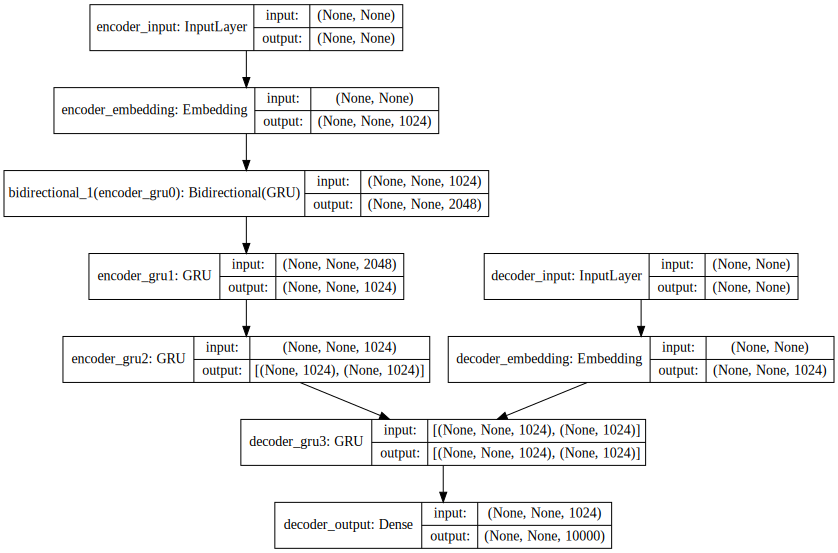

In [25]:
# visualise model as a graph
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
import pydot_ng as pydot
import graphviz as graphviz
SVG(model_to_dot(model,show_shapes=True).create(prog='dot', format='svg'))

### Graph the inference model

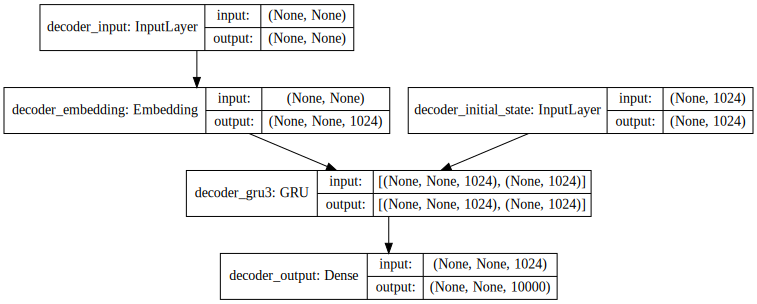

In [26]:
# visualise encoder model as a graph
SVG(model_to_dot(decoder_model,show_shapes=True).create(prog='dot', format='svg'))

# Train the model

In [27]:
# custom loss function since sparse does not work: https://github.com/tensorflow/tensorflow/issues/17150
def sparse_cross_entropy(y_true, y_pred):
    # Calculate the loss. This outputs a 2-rank tensor of shape [batch_size, sequence_length]
    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y_true, logits=y_pred)
    loss_mean = tf.reduce_mean(loss)
    return loss_mean

In [28]:
decoder_target = tf.placeholder(dtype='int32', shape=(None, None))

In [29]:
model.compile(optimizer='rmsprop',
              loss=sparse_cross_entropy,
              target_tensors=[decoder_target])

In [30]:
# call backs to stop model when it does not improve more
path_checkpoint = 'tgc_checkpoint.keras'
callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                      monitor='val_loss',
                                      verbose=1,
                                      save_weights_only=True,
                                      save_best_only=True)

callback_early_stopping = EarlyStopping(monitor='val_loss', 
                                        patience=3, 
                                        verbose=1)

callbacks = [callback_early_stopping,
             callback_checkpoint]

In [31]:
# Note that `decoder_target_data` needs to be one-hot encoded, rather than sequences of integers like `decoder_input_data`
history = model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
                    batch_size=batch_size,
                    epochs=numEpochs,
                    validation_split=0.2,
                    callbacks=callbacks)
model.save('TGC_trans.h5')

Train on 80000 samples, validate on 20000 samples
Epoch 1/10
80000/80000 [==============================] - 551s 7ms/step - loss: 2.3117 - val_loss: 2.2769
Epoch 00001: val_loss improved from inf to 2.27689, saving model to tgc_checkpoint.keras
Epoch 2/10
80000/80000 [==============================] - 541s 7ms/step - loss: 1.8205 - val_loss: 2.1049
Epoch 00002: val_loss improved from 2.27689 to 2.10493, saving model to tgc_checkpoint.keras
Epoch 3/10
80000/80000 [==============================] - 544s 7ms/step - loss: 1.6818 - val_loss: 2.0245
Epoch 00003: val_loss improved from 2.10493 to 2.02455, saving model to tgc_checkpoint.keras
Epoch 4/10
80000/80000 [==============================] - 543s 7ms/step - loss: 1.5853 - val_loss: 1.9656
Epoch 00004: val_loss improved from 2.02455 to 1.96562, saving model to tgc_checkpoint.keras
Epoch 5/10
80000/80000 [==============================] - 543s 7ms/step - loss: 1.5088 - val_loss: 1.9301
Epoch 00005: val_loss improved from 1.96562 to 1.930

C:\Users\ThomasGordon\Anaconda3\lib\site-packages\keras\engine\topology.py:2368: UserWarning: Layer decoder_gru3 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'encoder_gru2/while/Exit_2:0' shape=(?, 1024) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  str(node.arguments) + '. They will not be included '


In [32]:
history_dict = history.history
history_dict.keys()

dict_keys(['val_loss', 'loss'])

In [33]:
import matplotlib.pyplot as plt
plt.show()

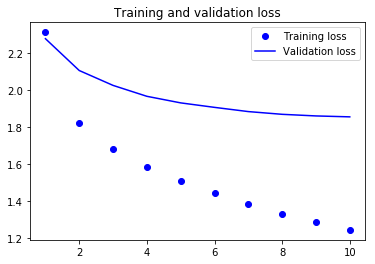

In [34]:
# plotter historikken for 'loss'
loss     = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss)+1)
plt.plot(epochs, loss, 'bo', label='Training loss')       # bo = "blue dot"
plt.plot(epochs, val_loss, 'b', label='Validation loss')  # b  = "solid blue line"
plt.title('Training and validation loss')
plt.legend()
plt.show()

# Doing translation

In [35]:
# function that does the translation
def decode_sequence(input_seq):
   
    # tokenize the text to be translated, and reverse
    input_tokens = tokenizer_inp.texts_to_sequences([input_seq])
    
    # Reverse the token-sequences
    #input_tokens = [list(reversed(x)) for x in input_tokens]

    # Pad sequence
    input_tokens = pad_sequences(input_tokens,
                                 maxlen=max_tokens_input,
                                 padding='post',
                                 truncating='post')

    # encode the input sentence
    states_value = encoder_model.predict(input_tokens)
    
    # Generate empty target sequence of length 1 and insert start token
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = token_start    #

    # sampling loop to generate translated words using decoder, word by word
    stop_condition = False
    decoded_sentence = ''
    
    while not stop_condition:  
        # predict one next word, decoder returns probabilities for all words/tokens
        output_tokens, h = decoder_model.predict([target_seq] + [states_value])
        
        # pick most probable token / word. Result '0' is a fault, 0 is reserved to tokenizer
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        if sampled_token_index>0:
            sampled_word = index_to_word_target[sampled_token_index]
        else:
            sampled_word = 'eeee'
        
        # append most probable word to sentende
        decoded_sentence += ' '+sampled_word
        
        # Exit condition: either hit max length or find stop character.
        if (sampled_word == 'eeee' or len(decoded_sentence) > 222):
            stop_condition = True
        
        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index
        
        # Update states, so they can be re-injected in next token/word prediction
        states_value = h

    return decoded_sentence

### Doing translation ...

In [36]:
# testing on known short sentences from training data
for idx in range(1000, 1010):
    input_seq = input_texts[idx]
    decoded_sentence = decode_sequence(input_seq)
    print(input_seq, '\n ==> ', decoded_sentence, '\n\n')

De købte det. 
 ==>   they bought it eeee 


De købte den. 
 ==>   they bought it eeee 


De skændtes. 
 ==>   they eeee 


De vil have mere. 
 ==>   they want to be eeee 


De var mine. 
 ==>   they were my friend eeee 


De er idioter. 
 ==>   they're eeee 


Tænk over det. 
 ==>   think about it eeee 


Det her er kedeligt. 
 ==>   it's this eeee 


Det er min hund. 
 ==>   it's my dog eeee 


Vi får se. 
 ==>   we are going to get married eeee 




In [37]:
# testing on known long sentences from training data
for idx in range(15000, 15010):
    input_seq = input_texts[idx]
    decoded_sentence = decode_sequence(input_seq)
    print(input_seq, '\n ==> ', decoded_sentence, '\n\n')

(Den således ændrede dagsorden godkendtes) 
 ==>   the committee on budgetary control was adopted eeee 


Sikkerhedsrådgivere for transport af farligt gods 
 ==>   the second pillar of the common agricultural policy eeee 


Næste punkt på dagsordenen er betænkning (A5-0105/1999) af Koch for Udvalget om Regionalpolitik, Transport og Turisme om Rådets fælles holdning med henblik på vedtagelse af Europa-Parlamentets og Rådets direktiv om minimumseksamenskravene for sikkerhedsrådgivere i forbindelse med transport af farligt gods med jernbane eller ad vej eller indre vandveje (C5-0208/1999 - 1998/0106(COD)). 
 ==>   the next item is the report a5 2000 by mr on behalf of the committee on legal affairs and the internal market on the proposal for a council regulation ec on the conclusion of the trans european conventional rail system com 


Ærede fru kommissær, ærede formand, kære kolleger, jeg bifalder Rådets fælles holdning om harmonisering af uddannelsen af sikkerhedsrådgivere i forbindelse

In [38]:
# testing on unknown sentences from validation data
for idx in range(90000, 90010):
    input_seq = input_texts[idx]
    decoded_sentence = decode_sequence(input_seq)
    print(input_seq, '\n ==> ', decoded_sentence, '\n\n')

Når det drejer sig om dødsstraf, er en retsvildfarelse selvfølgelig særligt alvorlig. Vi må ikke glemme, at man i sådanne tilfælde har indrømmet, at der var sket en retsvildfarelse, og det var ikke tilfældigt, at der var tale om personer, som ikke havde råd til dyre advokater. 
 ==>   when it comes to the situation in iraq we have no problem in this area and we should not be discussing this issue today eeee 


Når også retssystemet fungerer godt i USA, er det efter min mening, fordi advokaterne bliver virkeligt godt betalt, men det bliver de jo af dem, der har råd til det. 
 ==>   when the time comes to the issue of the issue of the issue of the issue of the issue of the issue of the issue of the issue of the issue of the issue of the issue of the issue of the issue of the issue of the peace process 


Vi anmoder derfor om, at denne dom bliver omstødt, og vi anmoder om, at Parlamentets formandskab - også i betragtning af det dokument, som adskillige parlamentsmedlemmer har undertegnet 

In [39]:
input_seq = 'vi ses'
decoded_sentence = decode_sequence(input_seq)
print(input_seq, '\n ==> ', decoded_sentence, '\n\n')

vi ses 
 ==>   see you eeee 




In [40]:
input_seq = 'Idag kan man læse i avisen at Danmark er blevet fornuftigt'
decoded_sentence = decode_sequence(input_seq)
print(input_seq, '\n ==> ', decoded_sentence, '\n\n')

Idag kan man læse i avisen at Danmark er blevet fornuftigt 
 ==>   can the council say that the court of auditors was not amended eeee 




In [41]:
input_seq = 'Kvinde står frem med anklager mod højesteretkandidat'
decoded_sentence = decode_sequence(input_seq)
print(input_seq, '\n ==> ', decoded_sentence, '\n\n')

Kvinde står frem med anklager mod højesteretkandidat 
 ==>   the ship is stuck in the eeee 




In [42]:
input_seq = 'Kvinde står frem med anklager mod højesteret'
decoded_sentence = decode_sequence(input_seq)
print(input_seq, '\n ==> ', decoded_sentence, '\n\n')

Kvinde står frem med anklager mod højesteret 
 ==>   the ship is stuck in the eeee 




In [43]:
input_seq = 'Han har kategorisk afvist anklagerne'
decoded_sentence = decode_sequence(input_seq)
print(input_seq, '\n ==> ', decoded_sentence, '\n\n')

Han har kategorisk afvist anklagerne 
 ==>   he has made a mistake eeee 




In [44]:
input_seq = 'Danmark er et dejligt land'
decoded_sentence = decode_sequence(input_seq)
print(input_seq, '\n ==> ', decoded_sentence, '\n\n')

Danmark er et dejligt land 
 ==>   greece is a country eeee 


